<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Advanced Algorithm 4: Deep Factorization Machine Classifier (Undersampled)</h1> 
<h2 style="text-align: center;" markdown="3">Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction) 
[Data Setup](#data-setup) 

[Deep Factorization Machine Classifier](#all-feats)  
&nbsp;&nbsp;&nbsp;[Set Parameters](#undersampling)  
&nbsp;&nbsp;&nbsp;[Run Model](#oversampling)

[Compare to Other Advanced Models](#compare)

[Predict on Other Years of Indonesia Survey Data](#robust)

[Summary](#summary)

# Deep Factorization Machine Classifier (Undersampled) Introduction <a class="anchor" id="introduction"></a>

All introductory material for the deep factorization machine (DeepFM) classifer can be found in the previous notebook. This notebook contains exactly the same code, except that undersampled data is used to train the model.

By imposing a class balancing technique, we hope to improve the recall and overall performance of the model.

# Data setup <a class="anchor" id="data-setup"></a>

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold

# model functions
sys.path.append('../src/models/')


from deepfm import config
# from deepfm.metrics import gini_norm, f1
from deepfm.DeepFM import DeepFM
from deepfm.DataReader import FeatureDictionary, DataParser
from deepfm.metrics import gini_norm, f1

# from deepfm.DeepFM import DeepFM
from deepfm.main import run_base_model_dfm
from deepfm.main import load_data_for_deepfm

# country loading
sys.path.append("../../")
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from data.sampler import Sampler
# eval
sys.path.append("../")
from evaluation import calculate_metrics, evaluate_model, load_model

ALGORITHM_NAME = 'deepfm'
COUNTRY = 'idn'
STORE_MODEL = True

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Using TensorFlow backend.


The only difference between this notebook and the previous one is that we load an undersampled version of the data here. This can be seen from the `undersample=True` flag in the data loading function.

For the sake of brevity, we will omit most commentary after this cell and get right to the results.

In [2]:
# load data
dfTrain, dfTest, X_train, y_train, X_test, ids_test, cat_features_indices = load_data_for_deepfm(COUNTRY, undersample=True)

# folds for cross-validation
folds = list(StratifiedKFold(n_splits=config.NUM_SPLITS, shuffle=True,
                             random_state=config.RANDOM_SEED).split(X_train, y_train))

X shape before resampling:  (53132, 453)
X shape after undersampling:  (9584, 453)


# Deep Factorization Machine Classifier <a class="anchor" id="#all-feats"></a>

## Set parameters

Here we will set the parameters for the DeepFM model.
* `use_fm` tells the constructor to use the factorization machine for interactions (the wide component of the model)
* `use_deep` tells the constructor to use the deep component of the model
* `embedding_size` controls the feature embedding
* `dropout_fm` uses dropout in the factorization machine to help avpod overfitting
* `deep_layers` controls the number of layers and dimensionality in the deep part of the network
* `dropout_deep` controls dropout in the deep part of the network
* `deep_layers_activation` determines the activation function used between layers (the nonlinearity)
* `epoch` the number of passes to make through the data when training
* `batch_size` the amount of data to fit for each iteration during an epoch
* `learning_rate` the gradient descent parameter that controls the size of the step during backpropogation (optimization)
* `optimizer_type` the optimization method to use for gradient descent
* `batch_norm` whether to use batch normalization, which controls the size of gradients during optimization
* `batch_norm_decay` controls how batch normalization is decreased as training progresses
* `l2_reg` size og the constant multiplier for the regularization term
* `verbose` controls model output during training
* `eval_metric` metric used to score the model (no relation to training)
* `random_seed` seed for the model


In [3]:
dfm_params = {
    "use_fm": True,
    "use_deep": True,
    "embedding_size": 8,
    "dropout_fm": [1.0, 1.0],
    "deep_layers": [64, 32, 32, 16, 8],
    "dropout_deep": [0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    "deep_layers_activation": tf.nn.relu,
    "epoch": 50,
    "batch_size": 1024,
    "learning_rate": 0.01,
    "optimizer_type": "adam",
    "batch_norm": 1,
    "batch_norm_decay": 0.995,
    "l2_reg": 0.001,
    "verbose": True,
    "eval_metric": f1,
    "random_seed": config.RANDOM_SEED,
}

## Run model

In [4]:
y_train_dfm, y_test_dfm, dfm = run_base_model_dfm(dfTrain, dfTest, folds, dfm_params)

#params: 244325
[1] train-result=0.3158, valid-result=0.2800 [2.3 s]
[2] train-result=0.7924, valid-result=0.7927 [1.7 s]
[3] train-result=0.7777, valid-result=0.7791 [1.7 s]
[4] train-result=0.8128, valid-result=0.8089 [1.7 s]
[5] train-result=0.8342, valid-result=0.8227 [1.7 s]
[6] train-result=0.8494, valid-result=0.8422 [1.8 s]
[7] train-result=0.8536, valid-result=0.8482 [1.7 s]
[8] train-result=0.8268, valid-result=0.8189 [1.7 s]
[9] train-result=0.8676, valid-result=0.8607 [1.7 s]
[10] train-result=0.8702, valid-result=0.8612 [1.7 s]
[11] train-result=0.8834, valid-result=0.8731 [1.8 s]
[12] train-result=0.8292, valid-result=0.8122 [1.7 s]
[13] train-result=0.8768, valid-result=0.8705 [1.7 s]
[14] train-result=0.8803, valid-result=0.8691 [1.7 s]
[15] train-result=0.8903, valid-result=0.8727 [1.7 s]
[16] train-result=0.8864, valid-result=0.8650 [1.7 s]
[17] train-result=0.8900, valid-result=0.8692 [1.8 s]
[18] train-result=0.8880, valid-result=0.8655 [1.7 s]
[19] train-result=0.8

Now we evaluate the model as usual. First we make predictions, and then evaluate the model based on the various metrics we've considered before. 

We'll compare the results to the other advanced models considered so far and see if undersampling helped the performance.

In [5]:
# get test preds
y_test = dfTest['target'].values.astype(int)
y_pred = np.round(y_test_dfm.ravel())
y_prob = y_test_dfm.ravel()

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


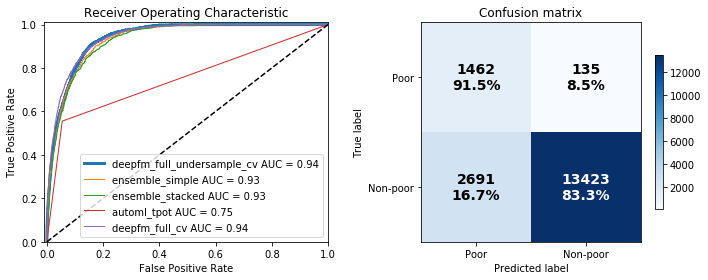

,deepfm_full_undersample_cv,ensemble_simple,ensemble_stacked,automl_tpot,deepfm_full_cv
accuracy,0.840438,0.845008,0.827208,0.896794,0.932415
recall,0.915466,0.873189,0.886484,0.555481,0.525986
precision,0.352035,0.418192,0.390749,0.592262,0.65625
f1,0.508522,0.565535,0.542411,0.573282,0.583942
cross_entropy,0.36728,0.34436,0.352263,0.625172,0.161349
roc_auc,0.939532,0.93394,0.929823,0.750474,0.943099
cohen_kappa,0.434918,0.464792,0.44074,0.472997,0.547647


In [6]:
compare_to = ['ensemble_simple', 'ensemble_stacked', 'automl_tpot', 'deepfm_full_cv']

metrics = evaluate_model(y_test, 
                         y_pred, 
                         y_prob,
                         compare_models=compare_to,
                         model_name='full_undersample_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

As hoped for, the recall on DeepFM has drastically improved! Comparing this result to the originally trained DeepFM model however, we see that the improvement in recall has come at the price of the precision, which is now the lowest of all models shown above.

# Predict On Other Years Of Indonesia Survey Data <a class="anchor" id="predict-on-other-years-of-indonesia-survey-data"></a>

As mentioned in the previous notebook, we will use our trained DeepFM model here to predict on other years of survey data and save those results.

In [7]:
# instantiate data parser to prepare the data
fd = FeatureDictionary(dfTrain=dfTrain, dfTest=dfTest,
                       numeric_cols=config.NUMERIC_COLS,
                       ignore_cols=config.IGNORE_COLS)
data_parser = DataParser(feat_dict=fd)

# 2011
country = 'idn-2011'
dfTest_2011, X_test_2011, ids_test_2011, cat_features_indices_2011 = load_data_for_deepfm('idn-2011', test_only=True)
Xi_test_2011, Xv_test_2011, y_test_2011 = data_parser.parse(df=dfTest_2011, has_label=True)

# 2013
dfTest_2013, X_test_2013, ids_test_2013, cat_features_indices_2013 = load_data_for_deepfm('idn-2013', test_only=True)
Xi_test_2013, Xv_test_2013, y_test_2013 = data_parser.parse(df=dfTest_2013, has_label=True)

# 2014
dfTest_2014, X_test_2014, ids_test_2014, cat_features_indices_2014 = load_data_for_deepfm('idn-2014', test_only=True)
Xi_test_2014, Xv_test_2014, y_test_2014 = data_parser.parse(df=dfTest_2014, has_label=True)

## Predict 2011

We'll predict and save the results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


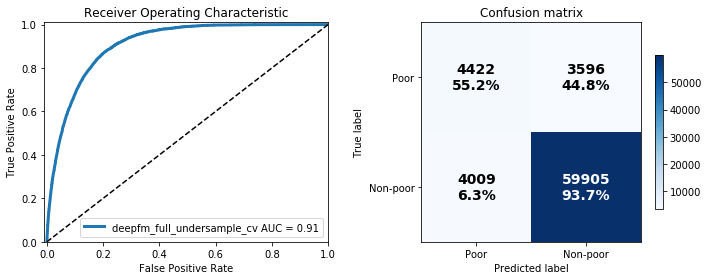

,deepfm_full_undersample_cv
accuracy,0.894275
recall,0.551509
precision,0.524493
f1,0.537662
cross_entropy,0.280025
roc_auc,0.908701
cohen_kappa,0.478017


In [8]:
y_test_2011_preds = dfm.predict(Xi_test_2011, Xv_test_2011)

# get test preds
y_test_2011 = dfTest_2011['target'].values.astype(int)
y_pred_2011 = np.round(y_test_2011_preds.ravel())
y_prob_2011 = y_test_2011_preds.ravel()

metrics = evaluate_model(y_test_2011, 
                         y_pred_2011, 
                         y_prob_2011, 
                         model_name='full_undersample_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2011',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

## Predict 2013

We'll predict and save the results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


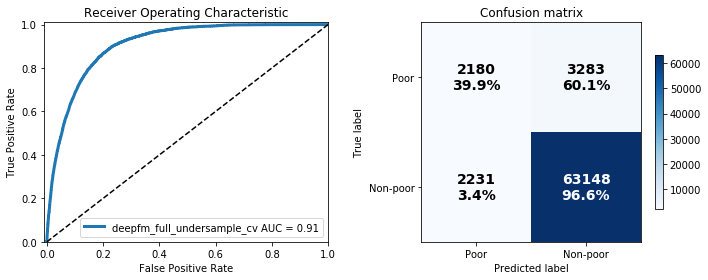

,deepfm_full_undersample_cv
accuracy,0.922165
recall,0.399048
precision,0.494219
f1,0.441564
cross_entropy,0.200481
roc_auc,0.907161
cohen_kappa,0.400241


In [9]:
y_test_2013_preds = dfm.predict(Xi_test_2013, Xv_test_2013)

# get test preds
y_test_2013 = dfTest_2013['target'].values.astype(int)
y_pred_2013 = np.round(y_test_2013_preds.ravel())
y_prob_2013 = y_test_2013_preds.ravel()

metrics = evaluate_model(y_test_2013, 
                         y_pred_2013, 
                         y_prob_2013, 
                         model_name='full_undersample_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2013',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

## Predict 2014

We'll predict and save the results.

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


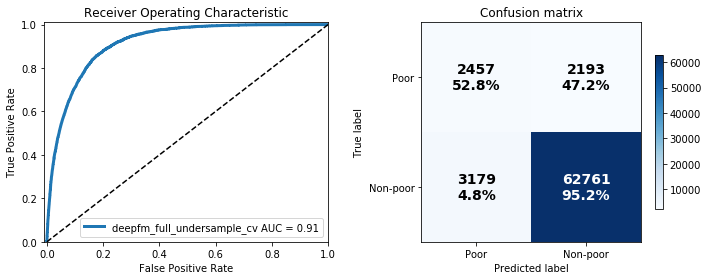

,deepfm_full_undersample_cv
accuracy,0.923899
recall,0.528387
precision,0.435947
f1,0.477737
cross_entropy,0.19737
roc_auc,0.914623
cohen_kappa,0.437102


In [10]:
y_test_2014_preds = dfm.predict(Xi_test_2014, Xv_test_2014)

# get test preds
y_test_2014 = dfTest_2014['target'].values.astype(int)
y_pred_2014 = np.round(y_test_2014_preds.ravel())
y_prob_2014 = y_test_2014_preds.ravel()

metrics = evaluate_model(y_test_2014, 
                         y_pred_2014, 
                         y_prob_2014, 
                         model_name='full_undersample_cv',
                         prefix=ALGORITHM_NAME,
                         country='idn-2014',
                         predict_pov_rate=False,
                         store_model=STORE_MODEL)

# Summary <a class="anchor" id="summary"></a>

The Undersampled DeepFM model is a top performer in recall, and pretty competative in most other metrics, but it has sufered in its precision from using undersampled data. In the next notebook, we'll consider the results from these advanced models in more detail, and compare them to some of top performing models from the first part of the project.